# ARISC - project


Import necessary libraries and moduels

In [14]:
# import cv2
# import os
# import re
import datetime
import numpy as np
import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from collections import Counter
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, classification_report, accuracy_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras.utils import to_categorical
# from keras.regularizers import l2
# from functools import partial
# import keras.backend as K
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro, norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

Definition of every funtions used in project

In [8]:
v1 = 'v1'
thdv1 = 'thdv1'
f1 = 'f1'

time_round_s = 'time_round_s'
time = 'time'

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Columns Name


first_day = datetime.datetime.strptime(f'{2023}-{37}-1', "%Y-%W-%w")
    
    # Tworzymy tablicę dla dat w danym tygodniu
dates_in_first_week = [first_day + datetime.timedelta(days=i) for i in range(7)]
dates_in_first_week_str = [date.strftime("%Y%m%d") for date in dates_in_first_week]
dates_in_second_week = [first_day + datetime.timedelta(days=i+7) for i in range(7)]
dates_in_second_week_str = [date.strftime("%Y%m%d") for date in dates_in_second_week]
    
first_sec_first_week = dates_in_first_week[0].replace(hour=0, minute=0, second=0, microsecond=0)
last_sec_first_week = dates_in_first_week[-1].replace(hour=23, minute=59, second=59, microsecond=999)
first_sec_second_week = dates_in_second_week[0].replace(hour=0, minute=0, second=0, microsecond=0)
last_sec_second_week = dates_in_second_week[-1].replace(hour=23, minute=59, second=59, microsecond=999)
print(f'first_sec_first_week: {first_sec_first_week}, last_sec_first_week: {last_sec_first_week}')
print(f'first_sec_second_week: {first_sec_second_week}, last_sec_second_week: {last_sec_second_week}')

rpi_power_v1_temp =  'v1/rpi_power_v1_{0}.csv'
rpi_power_v1_first_week_days =  [rpi_power_v1_temp.format(date) for date in dates_in_first_week_str]
rpi_power_v1_second_week_days =  [rpi_power_v1_temp.format(date) for date in dates_in_second_week_str]

rpi_power_thdv1_temp =  'thdv1/rpi_power_thdv1_{0}.csv'
rpi_power_thdv1_first_week_days =  [rpi_power_thdv1_temp.format(date) for date in dates_in_first_week_str]
rpi_power_thdv1_second_week_days =  [rpi_power_thdv1_temp.format(date) for date in dates_in_second_week_str]

rpi_power_f_temp =  'f/rpi_power_f_{0}.csv'
rpi_power_f_first_week_days =  [rpi_power_f_temp.format(date) for date in dates_in_first_week_str]
rpi_power_f_second_week_days =  [rpi_power_f_temp.format(date) for date in dates_in_second_week_str]

print(rpi_power_v1_first_week_days)
print(rpi_power_v1_second_week_days)

first_sec_first_week: 2023-09-11 00:00:00, last_sec_first_week: 2023-09-17 23:59:59.000999
first_sec_second_week: 2023-09-18 00:00:00, last_sec_second_week: 2023-09-24 23:59:59.000999
['v1/rpi_power_v1_20230911.csv', 'v1/rpi_power_v1_20230912.csv', 'v1/rpi_power_v1_20230913.csv', 'v1/rpi_power_v1_20230914.csv', 'v1/rpi_power_v1_20230915.csv', 'v1/rpi_power_v1_20230916.csv', 'v1/rpi_power_v1_20230917.csv']
['v1/rpi_power_v1_20230918.csv', 'v1/rpi_power_v1_20230919.csv', 'v1/rpi_power_v1_20230920.csv', 'v1/rpi_power_v1_20230921.csv', 'v1/rpi_power_v1_20230922.csv', 'v1/rpi_power_v1_20230923.csv', 'v1/rpi_power_v1_20230924.csv']


In [3]:
def read_and_merge_csv_files(paths, value_name):
    dfs = []
    for path in paths:
        df = pd.read_csv(path, names=[time, value_name])
        df[time] = pd.to_datetime(df[time], unit='ms')  # Konwersja na datę i zmniejszenie dokładności do sekund
        df[time_round_s] = pd.to_datetime(df[time], unit='ms').round('1s')
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.sort_values(by=time, inplace=True)
    return merged_df

def get_constant_time_index(start, stop):
    return pd.date_range(start=start, end=stop, freq='S')

def check_df_quality(df, name):
    print(f"check_df_quality for {name}:")
    print(df.head(10))
    print("Info:")
    print(df.info())
    print("Description:")
    print(df.describe())
    print("Has duplicated Time:")
    print(df[time].duplicated().any())
    time_diff = df[time].diff()
    print(f'Time diff value counts: {time_diff.value_counts()}')
    print(f'Time diff max: {time_diff.max()}, min: {time_diff.min()}')
    print(f'Value for max\n: {df.iloc[time_diff.argmax()]},\n  for min:\n {df.iloc[time_diff.argmin()]}')

    print("Has duplicated Time Round To s:")
    print(df[time_round_s].duplicated().any())
    time_diff = df[time_round_s].diff()
    print(f'Time diff value counts: {time_diff.value_counts()}')

def check_df_quality_with_index(df, name):
    print(f"check_df_quality for {name}:")
    print(df.head(10))
    print("Info:")
    print(df.info())
    print("Description:")
    print(df.describe())
    print("Has duplicated index:")
    print(df.index.duplicated().any())
    index_diff = df.index.to_series().diff()
    print(f'Index diff value counts: {index_diff.value_counts()}')
    print(f'Index diff max: {index_diff.max()}, min: {index_diff.min()}')
    print(f'Value for max: {df.iloc[index_diff.argmax()]},  min: {df.iloc[index_diff.argmin()]}')


def set_constant_time_index(df, index):
    df.set_index(index, inplace=True) 
    df.drop(columns=[time, time_round_s], inplace=True, errors='ignore')
    return df

def merge_on_index(df_tab):
    merged_df = df_tab[0]
    for df in df_tab[1:]:
        merged_df = merged_df.merge(df, left_index=True, right_index=True)
    
    return merged_df

def print_hist(df, title, bin_size = 50):
    plt.figure(figsize=(12, 4))
    
    plt.suptitle(title, fontsize=16)
# Histogram dla kolumny 'f1'
    plt.subplot(1, 3, 1)
    plt.hist(df['f1'], bins=bin_size, color='skyblue', edgecolor='black')
    plt.title('Histogram dla f1')

    # Histogram dla kolumny 'thdv1'
    plt.subplot(1, 3, 2)
    plt.hist(df['thdv1'], bins=bin_size, color='salmon', edgecolor='black')
    plt.title('Histogram dla thdv1')

    # Histogram dla kolumny 'v1'
    plt.subplot(1, 3, 3)
    plt.hist(df['v1'], bins=bin_size, color='lightgreen', edgecolor='black')
    plt.title('Histogram dla v1')

    plt.tight_layout()
    plt.show() 

def test_normalnosci(df, col_name, bin_size = 50):
    data_f1 = df[col_name]

    # Wizualna ocena - porównanie histogramu z rozkładem normalnym
    plt.figure(figsize=(8, 4))
    plt.hist(data_f1, bins=bin_size, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, np.mean(data_f1), np.std(data_f1))
    plt.plot(x, p, 'k', linewidth=2, label='Rozkład normalny')
    plt.title(f'Porównanie histogramu {col_name} z rozkładem normalnym')
    plt.legend()
    plt.show()

def correlation(df):
    # Obliczanie współczynnika korelacji Pearsona
    correlation_pearson = df.corr(method='pearson')
    print("Korelacja Pearsona:")
    print(correlation_pearson)

    # Obliczanie współczynnika korelacji Spearmana
    correlation_spearman = df.corr(method='spearman')
    print("\nKorelacja Spearmana:")
    print(correlation_spearman)

    for i in range(1, 11):
        autocorrelation = df.apply(lambda x: x.autocorr(lag=i))
        print(f"Autokorelacja (lag={i}) dla każdej kolumny:")
        print(autocorrelation)
    
    # Wykonanie transformaty Fouriera dla każdej kolumny
    fft_results = {}
    for column in df.columns:
        fft_results[column] = np.fft.fft(df[column])

    # Obliczenie częstotliwości próbkowania
    sampling_frequency = 1  # Załóżmy, że dane są równomiernie próbkowane co jednostkę czasu

    # Obliczenie częstotliwości
    frequencies = np.fft.fftfreq(len(df), d=sampling_frequency)

    # Wykres widma częstotliwości dla każdej kolumny
    plt.figure(figsize=(12, 8))
    for i, column in enumerate(fft_results, 1):
        plt.subplot(len(fft_results), 1, i)
        plt.plot(frequencies, np.abs(fft_results[column]))
        plt.title('Widmo częstotliwości dla ' + str(column))
        plt.xlabel('Częstotliwość')
        plt.ylabel('Amplituda')

    plt.tight_layout()
    plt.show()

def get_standarized(df):
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(df)
    return pd.DataFrame(df_standardized, columns=df.columns)
    
def GetTimeSeriesData(df: pd.DataFrame, target_col: str, row_per_series: int, forward_index: int, step_next: int=5):
    
    listNew = []
    listValue = []
    data_range = row_per_series
    data_range_index = data_range - 1
    full_range = row_per_series + forward_index
    full_range_index = full_range - 1
    start = 0
    print(df.__len__())
    for j in range(start, df.__len__() - full_range_index, step_next):
        listTemp = []
        for k in range(0, data_range):
            listTemp.append(df.iloc[k+j][df.columns.difference([target_col])].tolist())
            # listTemp.append(df[j + (k - start)])
        listNew.append(listTemp)
        # listValue.append((df.iloc[full_range_index+j][target_col] - df.iloc[data_range_index+j][target_col]) >= 0)
        listValue.append(df.iloc[full_range_index+j][target_col])
        # listValue.append((tab[j + stepForward][targetIndes] >= tab[j][targetIndes]).astype(int))
    return np.array(listNew), np.array(listValue)

def create_time_series(df, sequence_length, target_column, target_offset):

    X = []
    y = []
            
    for i in range(len(df) - sequence_length - target_offset + 1):
        X.append(df.iloc[i:i+sequence_length])
        y.append(df[target_column].iloc[i+sequence_length+target_offset-1])
            
    X = pd.concat(X, axis=1).T.reset_index(drop=True)
    y = pd.Series(y, name=target_column + "_target")
            
    return np.array(X), np.array(y)

def create_time_series_by_pandas(df, sequence_length, target_column, target_offset):
    X = pd.concat([df.shift(-i) for i in range(sequence_length)], axis=1).dropna()
    X = X.iloc[:-target_offset]
    # Utworzenie wartości docelowej
    y = df[target_column].shift(-(target_offset + sequence_length - 1)).dropna()
    y.name = f'{target_column}_target'
    print(X.shape)
    print(y.shape)
    return np.array(X).reshape(X.shape[0], sequence_length, -1), np.array(y)

In [4]:
df_v1_first_week = read_and_merge_csv_files(rpi_power_v1_first_week_days, 'v1')
df_v1_second_week = read_and_merge_csv_files(rpi_power_v1_second_week_days, 'v1')
print('\n---------------- V1 ---------------\n')
check_df_quality(df_v1_first_week, 'df_v1_first_week')
check_df_quality(df_v1_second_week, 'df_v1_second_week')

df_thdv1_first_week = read_and_merge_csv_files(rpi_power_thdv1_first_week_days, 'thdv1')
df_thdv1_second_week = read_and_merge_csv_files(rpi_power_thdv1_second_week_days, 'thdv1')
print('\n---------------- thdv1 ---------------\n')
check_df_quality(df_thdv1_first_week, 'df_thdv1_first_week')
check_df_quality(df_thdv1_second_week, 'df_thdv1_second_week')

df_f1_first_week = read_and_merge_csv_files(rpi_power_f_first_week_days, 'f1')
df_f1_second_week = read_and_merge_csv_files(rpi_power_f_second_week_days, 'f1')
print('\n---------------- f1 ---------------\n')
check_df_quality(df_f1_first_week, 'df_f1_first_week')
check_df_quality(df_f1_second_week, 'df_f1_second_week')



---------------- V1 ---------------

check_df_quality for df_v1_first_week:
                     time          v1        time_round_s
0 2023-09-11 00:00:00.364  226.932007 2023-09-11 00:00:00
1 2023-09-11 00:00:01.367  226.871002 2023-09-11 00:00:01
2 2023-09-11 00:00:02.366  226.811005 2023-09-11 00:00:02
3 2023-09-11 00:00:03.367  226.865997 2023-09-11 00:00:03
4 2023-09-11 00:00:04.365  226.867004 2023-09-11 00:00:04
5 2023-09-11 00:00:05.365  226.893997 2023-09-11 00:00:05
6 2023-09-11 00:00:06.367  226.673996 2023-09-11 00:00:06
7 2023-09-11 00:00:07.365  226.750000 2023-09-11 00:00:07
8 2023-09-11 00:00:08.365  226.904999 2023-09-11 00:00:08
9 2023-09-11 00:00:09.376  226.869995 2023-09-11 00:00:09
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604800 entries, 0 to 604799
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time          604800 non-null  datetime64[ns]
 1   v1         

In [5]:
print(f'second in week: {60*60*24*7}')
new_index_firts_week = get_constant_time_index(first_sec_first_week, last_sec_first_week)
print(f'new_index_firts_week count: {len(new_index_firts_week)}')
new_index_second_week = get_constant_time_index(df_v1_second_week[time].min(), df_v1_second_week[time].max())
print(f'new_index_second_week count: {len(new_index_second_week)}')


set_constant_time_index(df_v1_first_week, new_index_firts_week)
check_df_quality_with_index(df_v1_first_week, 'df_v1_first_week')

set_constant_time_index(df_thdv1_first_week, new_index_firts_week)
set_constant_time_index(df_f1_first_week, new_index_firts_week)

set_constant_time_index(df_v1_second_week, new_index_second_week)
set_constant_time_index(df_thdv1_second_week, new_index_second_week)
set_constant_time_index(df_f1_second_week, new_index_second_week)

second in week: 604800
new_index_firts_week count: 604800
new_index_second_week count: 604800
check_df_quality for df_v1_first_week:
                             v1
2023-09-11 00:00:00  226.932007
2023-09-11 00:00:01  226.871002
2023-09-11 00:00:02  226.811005
2023-09-11 00:00:03  226.865997
2023-09-11 00:00:04  226.867004
2023-09-11 00:00:05  226.893997
2023-09-11 00:00:06  226.673996
2023-09-11 00:00:07  226.750000
2023-09-11 00:00:08  226.904999
2023-09-11 00:00:09  226.869995
Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604800 entries, 2023-09-11 00:00:00 to 2023-09-17 23:59:59
Freq: S
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   v1      604800 non-null  float64
dtypes: float64(1)
memory usage: 9.2 MB
None
Description:
                  v1
count  604800.000000
mean      228.602391
std         2.269817
min       222.466995
25%       226.572998
50%       228.815994
75%       230.524002
max       234.423

,f1
2023-09-18 00:00:00.391,49.982208
2023-09-18 00:00:01.391,49.993385
2023-09-18 00:00:02.391,49.992092
2023-09-18 00:00:03.391,49.979053
2023-09-18 00:00:04.391,49.977890
...,...
2023-09-24 23:59:55.391,50.022221
2023-09-24 23:59:56.391,50.024601
2023-09-24 23:59:57.391,50.022526
2023-09-24 23:59:58.391,50.011322


In [6]:
full_data_first_week = merge_on_index([df_f1_first_week, df_thdv1_first_week, df_v1_first_week])
full_data_secnd_week = merge_on_index([df_f1_second_week, df_thdv1_second_week, df_v1_second_week])

print('\n---------------- First Week ---------------\n')
check_df_quality_with_index(full_data_first_week, 'full_data_first_week')
print('\n---------------- Second First ---------------\n')
check_df_quality_with_index(full_data_secnd_week, 'full_data_secnd_week')


---------------- First Week ---------------

check_df_quality for full_data_first_week:
                            f1     thdv1          v1
2023-09-11 00:00:00  49.991673  1.327824  226.932007
2023-09-11 00:00:01  49.984390  1.150213  226.871002
2023-09-11 00:00:02  49.982590  1.328247  226.811005
2023-09-11 00:00:03  49.978836  1.454799  226.865997
2023-09-11 00:00:04  49.977684  1.485011  226.867004
2023-09-11 00:00:05  49.977211  1.392771  226.893997
2023-09-11 00:00:06  49.974419  0.419978  226.673996
2023-09-11 00:00:07  49.971542  2.057928  226.750000
2023-09-11 00:00:08  49.966030  1.571200  226.904999
2023-09-11 00:00:09  49.971344  1.259536  226.869995
Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604800 entries, 2023-09-11 00:00:00 to 2023-09-17 23:59:59
Freq: S
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f1      604800 non-null  float64
 1   thdv1   604800 non-null  float64
 2   v1      60480

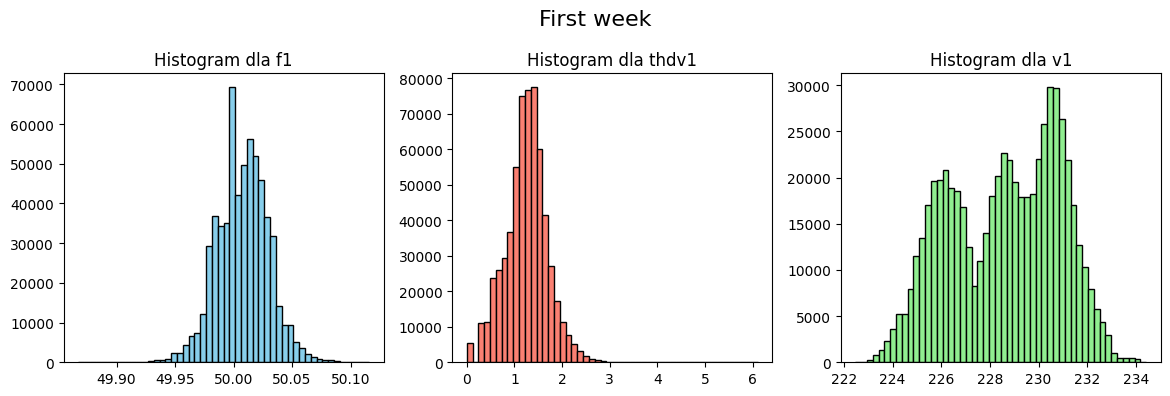

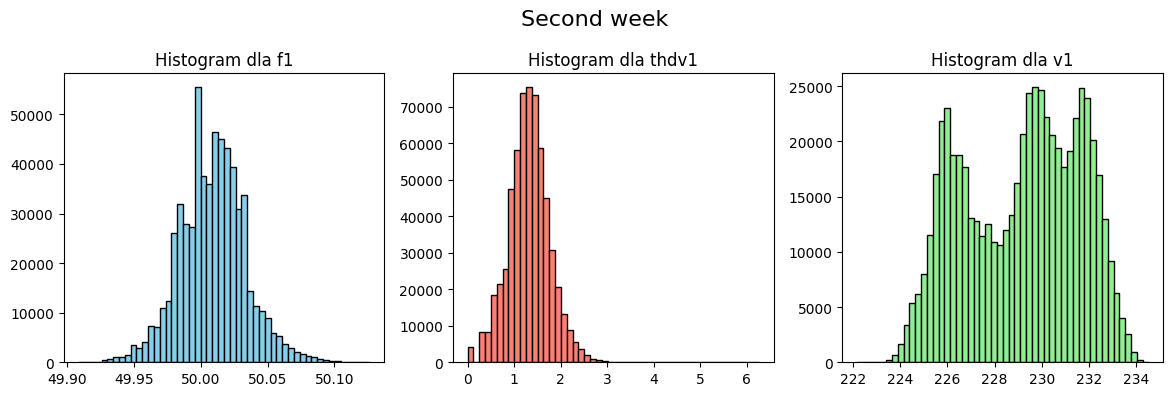

In [8]:
print_hist(full_data_first_week, "First week")
print_hist(full_data_secnd_week, "Second week")


---------------- First Week ---------------



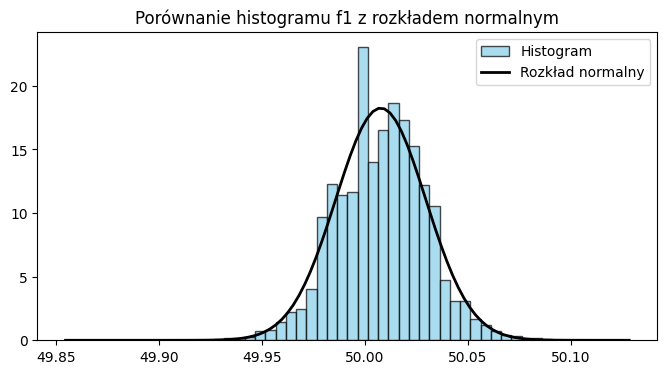

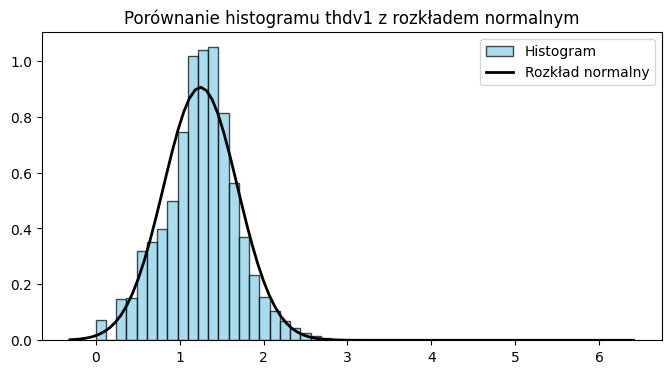

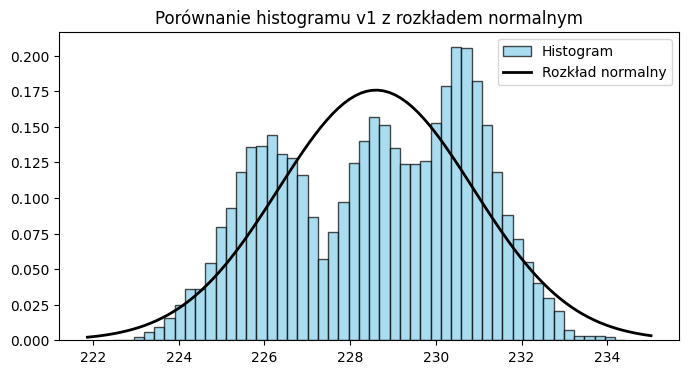


---------------- Second First ---------------



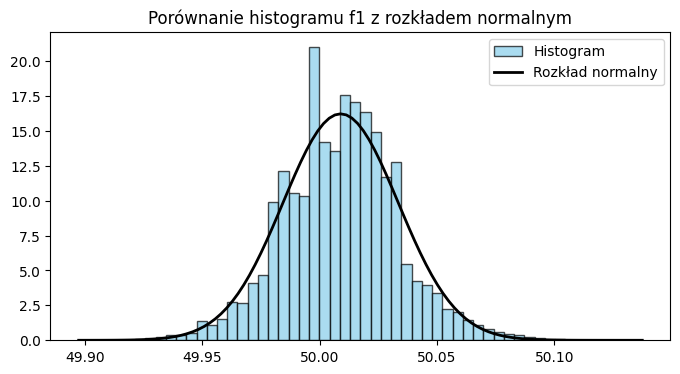

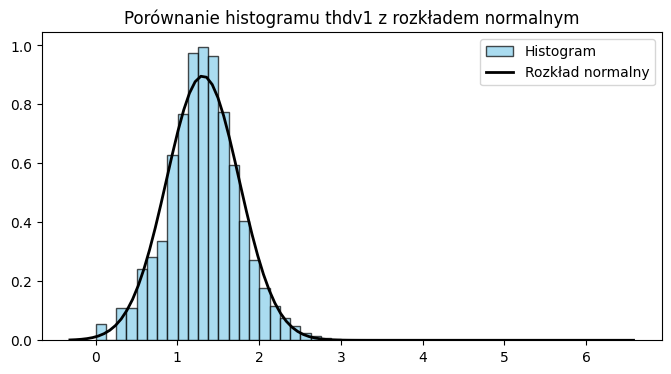

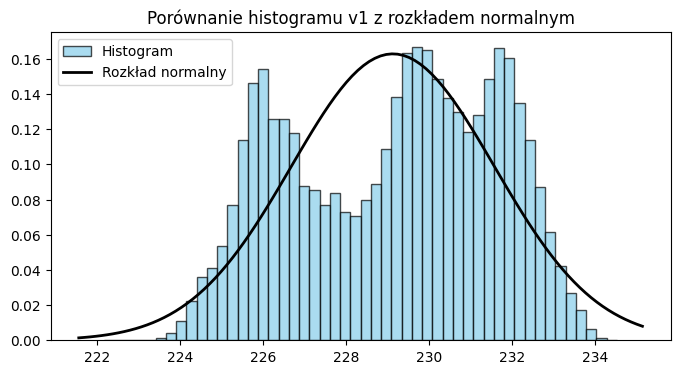

In [9]:
print('\n---------------- First Week ---------------\n')
test_normalnosci(full_data_first_week, 'f1')
test_normalnosci(full_data_first_week, 'thdv1')
test_normalnosci(full_data_first_week, 'v1')
print('\n---------------- Second First ---------------\n')
test_normalnosci(full_data_secnd_week, 'f1')
test_normalnosci(full_data_secnd_week, 'thdv1')
test_normalnosci(full_data_secnd_week, 'v1')


---------------- First Week ---------------

Korelacja Pearsona:
             f1     thdv1        v1
f1     1.000000  0.034089  0.027922
thdv1  0.034089  1.000000 -0.121041
v1     0.027922 -0.121041  1.000000

Korelacja Spearmana:
             f1     thdv1        v1
f1     1.000000  0.039527  0.006660
thdv1  0.039527  1.000000 -0.147556
v1     0.006660 -0.147556  1.000000
Autokorelacja (lag=1) dla każdej kolumny:
f1       0.964928
thdv1    0.183576
v1       0.998958
dtype: float64
Autokorelacja (lag=2) dla każdej kolumny:
f1       0.927321
thdv1    0.122802
v1       0.997559
dtype: float64
Autokorelacja (lag=3) dla każdej kolumny:
f1       0.922023
thdv1    0.132925
v1       0.996317
dtype: float64
Autokorelacja (lag=4) dla każdej kolumny:
f1       0.915788
thdv1    0.119545
v1       0.995177
dtype: float64
Autokorelacja (lag=5) dla każdej kolumny:
f1       0.908107
thdv1    0.115173
v1       0.994163
dtype: float64
Autokorelacja (lag=6) dla każdej kolumny:
f1       0.899937
thdv1    

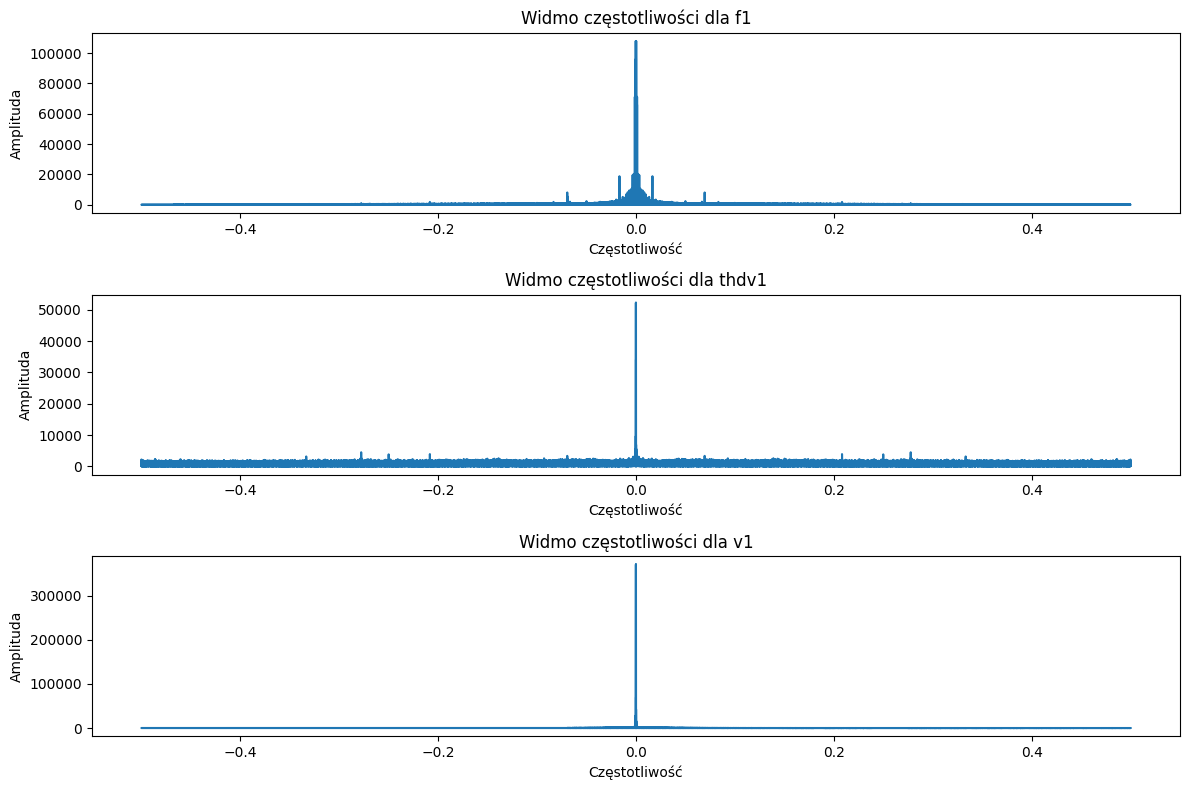


---------------- Second First ---------------

Korelacja Pearsona:
             f1     thdv1        v1
f1     1.000000 -0.028053 -0.039617
thdv1 -0.028053  1.000000  0.025188
v1    -0.039617  0.025188  1.000000

Korelacja Spearmana:
             f1     thdv1        v1
f1     1.000000 -0.025346 -0.051499
thdv1 -0.025346  1.000000  0.017198
v1    -0.051499  0.017198  1.000000
Autokorelacja (lag=1) dla każdej kolumny:
f1       0.971928
thdv1    0.260308
v1       0.999163
dtype: float64
Autokorelacja (lag=2) dla każdej kolumny:
f1       0.941607
thdv1    0.193030
v1       0.998029
dtype: float64
Autokorelacja (lag=3) dla każdej kolumny:
f1       0.937039
thdv1    0.196889
v1       0.997014
dtype: float64
Autokorelacja (lag=4) dla każdej kolumny:
f1       0.931927
thdv1    0.190226
v1       0.996079
dtype: float64
Autokorelacja (lag=5) dla każdej kolumny:
f1       0.925609
thdv1    0.183771
v1       0.995230
dtype: float64
Autokorelacja (lag=6) dla każdej kolumny:
f1       0.918723
thdv1  

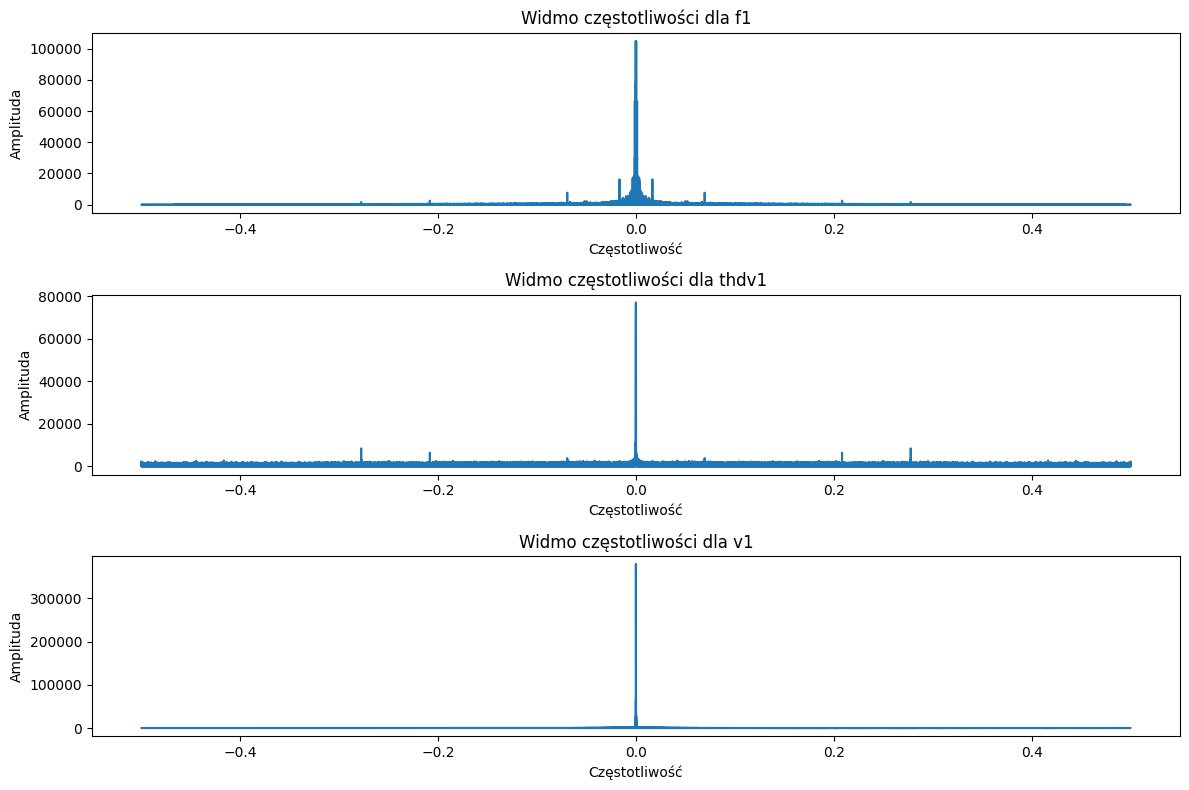

In [10]:
print('\n---------------- First Week ---------------\n')
correlation(get_standarized(full_data_first_week))
print('\n---------------- Second First ---------------\n')
correlation(get_standarized(full_data_secnd_week))

In [34]:
batch_size = 64
full_normalized_train =  get_standarized(full_data_first_week)
full_normalized_test =  get_standarized(full_data_secnd_week)

x_train_numpy, y_train_numpy = create_time_series_by_pandas(full_normalized_train, 30, v1, 5)
print(f'{x_train_numpy.shape}, {y_train_numpy.shape}')
x_train = torch.tensor(x_train_numpy, dtype=torch.float32)
y_train = torch.tensor(y_train_numpy, dtype=torch.float32)
# x_train = x_train.unsqueeze(1)
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


x_test_numpy, y_test_numpy = create_time_series_by_pandas(full_normalized_test, 30, v1, 5)
print(f'{x_test_numpy.shape}, {y_test_numpy.shape}')
x_test = torch.tensor(x_test_numpy, dtype=torch.float32)
y_test = torch.tensor(y_test_numpy, dtype=torch.float32)
# x_test = x_test.unsqueeze(1)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('------- index 0 ----------')
print(full_normalized_train[:31])
print(x_train[0])
print(y_train[0])

print('------- index 1 ----------')
print(full_normalized_train[1:32])
print(x_train[1])
print(y_train[1])

(604766, 90)
(604766,)
(604766, 30, 3), (604766,)
(604766, 90)
(604766,)
(604766, 30, 3), (604766,)
------- index 0 ----------
          f1     thdv1        v1
0  -0.732884  0.177095 -0.735912
1  -1.066099 -0.225993 -0.762788
2  -1.148486  0.178054 -0.789221
3  -1.320243  0.465265 -0.764993
4  -1.372957  0.533831 -0.764550
5  -1.394601  0.324491 -0.752658
6  -1.522371 -1.883266 -0.849582
7  -1.653981  1.834069 -0.816098
8  -1.906205  0.729438 -0.747811
9  -1.663058  0.022115 -0.763232
10 -1.607551  0.600029 -0.768079
11 -1.891368  0.599907 -0.764550
12 -1.634955  0.533504 -0.754856
13 -1.979341  0.177177 -0.760146
14 -2.289690  0.915683 -0.742083
15 -1.854887  0.600082 -0.753095
16 -1.797461  0.729344 -0.745169
17 -2.027168  0.021409 -0.738561
18 -1.862917  0.974537 -0.726662
19 -1.718739  0.599219 -0.727986
20 -1.644905  0.974495 -0.712128
21 -1.243616  0.323772 -0.710360
22 -1.160006  1.149587 -0.692297
23 -1.403503  0.099670 -0.693621
24 -1.312039  0.394360 -0.700673
25 -1.123875  0

In [36]:
def last_value_mae(y_true, x_series):
    last_value_pred = x_series[:, -1, 2]
    mae = mean_absolute_error(y_true, last_value_pred)
    r2 = r2_score(y_true,last_value_pred)
    return mae

def last_value_r2(y_true, x_series):
    last_value_pred = x_series[:, -1, 2]
    r2 = r2_score(y_true,last_value_pred)
    return r2

print(f"Train MAE: {last_value_mae(y_train,x_train)}, R2: {last_value_r2(y_train,x_train)}")
print(f"Test MAE: {last_value_mae(y_test,x_test)}, R2: {last_value_r2(y_test,x_test)}")

Train MAE: 0.07421860098838806, R2: 0.9883258348765861
Test MAE: 0.06672847270965576, R2: 0.9904608031853894


In [47]:
class LSTMRegressor(nn.Module):
    def __init__(self):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(3, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64).to(x.device)
        c0 = torch.zeros(1, x.size(0), 64).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Inicjalizacja modelu
model_lstm = LSTMRegressor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
# Przesunięcie modelu do urządzenia
model_lstm.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    model_lstm.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    model_lstm.eval()
    with torch.no_grad():
        train_predictions = []
        for inputs, targets in train_loader:
            targets = targets.unsqueeze(1)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_lstm(inputs)
            train_predictions.append(outputs.cpu().numpy())
        train_predictions = np.concatenate(train_predictions)

        train_mea = mean_absolute_error(y_train.numpy(), train_predictions)
        train_r2 = r2_score(y_train.numpy(), train_predictions)
            
        test_loss = 0.0
        test_predictions = []
        for inputs, targets in test_loader:
            targets = targets.unsqueeze(1)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_lstm(inputs)
            test_loss += criterion(outputs, targets).item() * inputs.size(0)
            test_predictions.append(outputs.cpu().numpy())
        test_predictions = np.concatenate(test_predictions)
        test_loss /= len(test_loader.dataset)

        test_mea = mean_absolute_error(y_test.numpy(), test_predictions)
        test_r2 = r2_score(y_test.numpy(), test_predictions)
    
    # Wyświetlanie wyników na konsoli
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train MEA: {train_mea:.4f}, Train R^2: {train_r2:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test MEA: {test_mea:.4f}, Test R^2: {test_r2:.4f}')

print('Training finished!')

cuda
Epoch [1/10], Train Loss: 0.0181, Train MEA: 0.1911, Train R^2: 0.9354
Test Loss: 0.0595, Test MEA: 0.1874, Test R^2: 0.9405
Epoch [2/10], Train Loss: 0.0124, Train MEA: 0.1702, Train R^2: 0.9470
Test Loss: 0.0482, Test MEA: 0.1663, Test R^2: 0.9518
Epoch [3/10], Train Loss: 0.0117, Train MEA: 0.1649, Train R^2: 0.9505
Test Loss: 0.0453, Test MEA: 0.1618, Test R^2: 0.9547
Epoch [4/10], Train Loss: 0.0114, Train MEA: 0.1559, Train R^2: 0.9568
Test Loss: 0.0398, Test MEA: 0.1533, Test R^2: 0.9602
Epoch [5/10], Train Loss: 0.0110, Train MEA: 0.1453, Train R^2: 0.9635
Test Loss: 0.0338, Test MEA: 0.1428, Test R^2: 0.9662
Epoch [6/10], Train Loss: 0.0106, Train MEA: 0.1279, Train R^2: 0.9731
Test Loss: 0.0244, Test MEA: 0.1251, Test R^2: 0.9756
Epoch [7/10], Train Loss: 0.0102, Train MEA: 0.1163, Train R^2: 0.9773
Test Loss: 0.0203, Test MEA: 0.1123, Test R^2: 0.9797
Epoch [8/10], Train Loss: 0.0099, Train MEA: 0.1120, Train R^2: 0.9789
Test Loss: 0.0187, Test MEA: 0.1073, Test R^2: 0.

In [50]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    model_lstm.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    model_lstm.eval()
    with torch.no_grad():
        train_predictions = []
        for inputs, targets in train_loader:
            targets = targets.unsqueeze(1)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_lstm(inputs)
            train_predictions.append(outputs.cpu().numpy())
        train_predictions = np.concatenate(train_predictions)

        train_mea = mean_absolute_error(y_train.numpy(), train_predictions)
        train_r2 = r2_score(y_train.numpy(), train_predictions)
            
        test_loss = 0.0
        test_predictions = []
        for inputs, targets in test_loader:
            targets = targets.unsqueeze(1)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_lstm(inputs)
            test_loss += criterion(outputs, targets).item() * inputs.size(0)
            test_predictions.append(outputs.cpu().numpy())
        test_predictions = np.concatenate(test_predictions)
        test_loss /= len(test_loader.dataset)

        test_mea = mean_absolute_error(y_test.numpy(), test_predictions)
        test_r2 = r2_score(y_test.numpy(), test_predictions)
    
    # Wyświetlanie wyników na konsoli
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train MEA: {train_mea:.4f}, Train R^2: {train_r2:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test MEA: {test_mea:.4f}, Test R^2: {test_r2:.4f}')

print('Training finished!')

Epoch [1/10], Train Loss: 0.0090, Train MEA: 0.0896, Train R^2: 0.9862
Test Loss: 0.0118, Test MEA: 0.0841, Test R^2: 0.9882
Epoch [2/10], Train Loss: 0.0090, Train MEA: 0.0880, Train R^2: 0.9866
Test Loss: 0.0114, Test MEA: 0.0824, Test R^2: 0.9886
Epoch [3/10], Train Loss: 0.0089, Train MEA: 0.0877, Train R^2: 0.9866
Test Loss: 0.0114, Test MEA: 0.0822, Test R^2: 0.9886
Epoch [4/10], Train Loss: 0.0089, Train MEA: 0.0868, Train R^2: 0.9869
Test Loss: 0.0112, Test MEA: 0.0812, Test R^2: 0.9888
Epoch [5/10], Train Loss: 0.0089, Train MEA: 0.0866, Train R^2: 0.9869
Test Loss: 0.0112, Test MEA: 0.0811, Test R^2: 0.9888
Epoch [6/10], Train Loss: 0.0089, Train MEA: 0.0875, Train R^2: 0.9867
Test Loss: 0.0113, Test MEA: 0.0821, Test R^2: 0.9887
Epoch [7/10], Train Loss: 0.0089, Train MEA: 0.0877, Train R^2: 0.9867
Test Loss: 0.0114, Test MEA: 0.0825, Test R^2: 0.9886
Epoch [8/10], Train Loss: 0.0089, Train MEA: 0.0911, Train R^2: 0.9859
Test Loss: 0.0122, Test MEA: 0.0860, Test R^2: 0.9878


In [53]:
batch_size = 64
full_normalized_train =  get_standarized(full_data_first_week)
full_normalized_test =  get_standarized(full_data_secnd_week)

x_train_numpy, y_train_numpy = create_time_series_by_pandas(full_normalized_train, 30, v1, 5)
print(f'{x_train_numpy.shape}, {y_train_numpy.shape}')
x_train = torch.tensor(x_train_numpy, dtype=torch.float32)
y_train = torch.tensor(y_train_numpy, dtype=torch.float32)
# x_train = x_train.unsqueeze(1)
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


x_test_numpy, y_test_numpy = create_time_series_by_pandas(full_normalized_test, 30, v1, 5)
print(f'{x_test_numpy.shape}, {y_test_numpy.shape}')
x_test = torch.tensor(x_test_numpy, dtype=torch.float32)
y_test = torch.tensor(y_test_numpy, dtype=torch.float32)
# x_test = x_test.unsqueeze(1)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('------- index 0 ----------')
print(full_normalized_train[:110])
print(x_train[0])
print(y_train[0])

print('------- index 1 ----------')
print(full_normalized_train[1:111])
print(x_train[1])
print(y_train[1])

(604766, 90)
(604766,)
(604766, 30, 3), (604766,)
(604766, 90)
(604766,)
(604766, 30, 3), (604766,)
------- index 0 ----------
           f1     thdv1        v1
0   -0.732884  0.177095 -0.735912
1   -1.066099 -0.225993 -0.762788
2   -1.148486  0.178054 -0.789221
3   -1.320243  0.465265 -0.764993
4   -1.372957  0.533831 -0.764550
..        ...       ...       ...
105 -0.892597  0.531825 -0.722259
106 -0.940249  0.176737 -0.724020
107 -1.253914  0.175852 -0.737680
108 -1.335429  0.324366 -0.748691
109 -1.381859  0.100907 -0.758385

[110 rows x 3 columns]
tensor([[-0.7329,  0.1771, -0.7359],
        [-1.0661, -0.2260, -0.7628],
        [-1.1485,  0.1781, -0.7892],
        [-1.3202,  0.4653, -0.7650],
        [-1.3730,  0.5338, -0.7645],
        [-1.3946,  0.3245, -0.7527],
        [-1.5224, -1.8833, -0.8496],
        [-1.6540,  1.8341, -0.8161],
        [-1.9062,  0.7294, -0.7478],
        [-1.6631,  0.0221, -0.7632],
        [-1.6076,  0.6000, -0.7681],
        [-1.8914,  0.5999, -0.7645

In [56]:
class CNN_TS(nn.Module):
    def __init__(self, input_channels):
        super(CNN_TS, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.fc1 = nn.Linear(256 * 2, 128) 
        self.fc2 = nn.Linear(128, 1)
        # self.dropout = nn.Dropout(0.2) 

    def forward(self, x):
        x = F.relu(self.conv1(x.permute(0, 2, 1)))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x) 
        x = self.fc2(x)
        return x

input_channels = 3  # liczba kanałów wejściowych
sequence_length = 30  
lr = 0.001
num_epochs = 30

# Funkcja treningowa
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_mae = 0.0
    total_samples = 0
    all_predictions = []
    all_targets = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        total_mae += mean_absolute_error(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy()) * inputs.size(0)
        total_samples += inputs.size(0)
        all_predictions.append(outputs.cpu().detach().numpy())
        all_targets.append(labels.cpu().detach().numpy())
    train_loss = running_loss / total_samples
    train_mae = total_mae / total_samples
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    r2 = r2_score(all_targets, all_predictions)
    return train_loss, train_mae, r2

# Funkcja walidacyjna
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_mae = 0.0
    total_samples = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            total_mae += mean_absolute_error(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy()) * inputs.size(0)
            total_samples += inputs.size(0)
            all_predictions.append(outputs.cpu().detach().numpy())
            all_targets.append(labels.cpu().detach().numpy())
    val_loss = running_loss / total_samples
    val_mae = total_mae / total_samples
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    r2 = r2_score(all_targets, all_predictions)
    return val_loss, val_mae, r2


# Tworzenie modelu i przeniesienie na odpowiednie urządzenie
model_cnn = CNN_TS(input_channels).to(device)

# Definicja funkcji straty (Mean Squared Error) i optymizatora
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=lr)

# Pętla treningowa
for epoch in range(num_epochs):
    train_loss, train_mae, train_r2 = train(model_cnn, train_loader, criterion, optimizer, device)
    val_loss, val_mae, val_r2 = validate(model_cnn, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train R2: {train_r2:.4f}")
    print(f"          Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val R2: {val_r2:.4f}")


Epoch 1/30, Train Loss: 0.0237, Train MAE: 0.1102, Train R2: 0.9763
          Val Loss: 0.2185, Val MAE: 0.3674, Val R2: 0.7815
Epoch 2/30, Train Loss: 0.0183, Train MAE: 0.0996, Train R2: 0.9817
          Val Loss: 0.1967, Val MAE: 0.3369, Val R2: 0.8034
Epoch 3/30, Train Loss: 0.0173, Train MAE: 0.0970, Train R2: 0.9827
          Val Loss: 0.1277, Val MAE: 0.2650, Val R2: 0.8723
Epoch 4/30, Train Loss: 0.0159, Train MAE: 0.0933, Train R2: 0.9841
          Val Loss: 0.0990, Val MAE: 0.2304, Val R2: 0.9010
Epoch 5/30, Train Loss: 0.0150, Train MAE: 0.0907, Train R2: 0.9850
          Val Loss: 0.0676, Val MAE: 0.1933, Val R2: 0.9324
Epoch 6/30, Train Loss: 0.0142, Train MAE: 0.0883, Train R2: 0.9858
          Val Loss: 0.0605, Val MAE: 0.1895, Val R2: 0.9395
Epoch 7/30, Train Loss: 0.0135, Train MAE: 0.0860, Train R2: 0.9865
          Val Loss: 0.0707, Val MAE: 0.2103, Val R2: 0.9293
Epoch 8/30, Train Loss: 0.0131, Train MAE: 0.0846, Train R2: 0.9869
          Val Loss: 0.0617, Val MAE: